<ipython-input-1-833225fae65c>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-1-833225fae65c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Bear_Market'].iloc[i + window - 1] = 1
<ipython-input-1-833225fae65c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Bear_Market'].iloc[i + window - 1] = 1
<ipython-input-1-833225fae65c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

Classification Report:
              precision    recall  f1-score   support

      하락장 없음       0.82      0.83      0.82       209
         하락장       0.81      0.81      0.81       196

    accuracy                           0.82       405
   macro avg       0.82      0.82      0.82       405
weighted avg       0.82      0.82      0.82       405

예측 결과:
2024-07-16의 예측: 하락장
2024-07-17의 예측: 하락장
2024-07-18의 예측: 하락장
2024-07-19의 예측: 하락장
2024-07-22의 예측: 하락장
2024-07-23의 예측: 하락장
2024-07-24의 예측: 하락장
2024-07-25의 예측: 하락장
2024-07-26의 예측: 하락장
2024-07-29의 예측: 하락장
2024-07-30의 예측: 하락장
2024-07-31의 예측: 하락장
2024-08-01의 예측: 하락장
2024-08-02의 예측: 하락장
2024-08-05의 예측: 하락장
2024-08-06의 예측: 하락장
2024-08-07의 예측: 하락장
2024-08-08의 예측: 하락장
2024-08-09의 예측: 하락장
2024-08-12의 예측: 하락장
2024-08-13의 예측: 하락장
2024-08-14의 예측: 하락장 없음


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but 

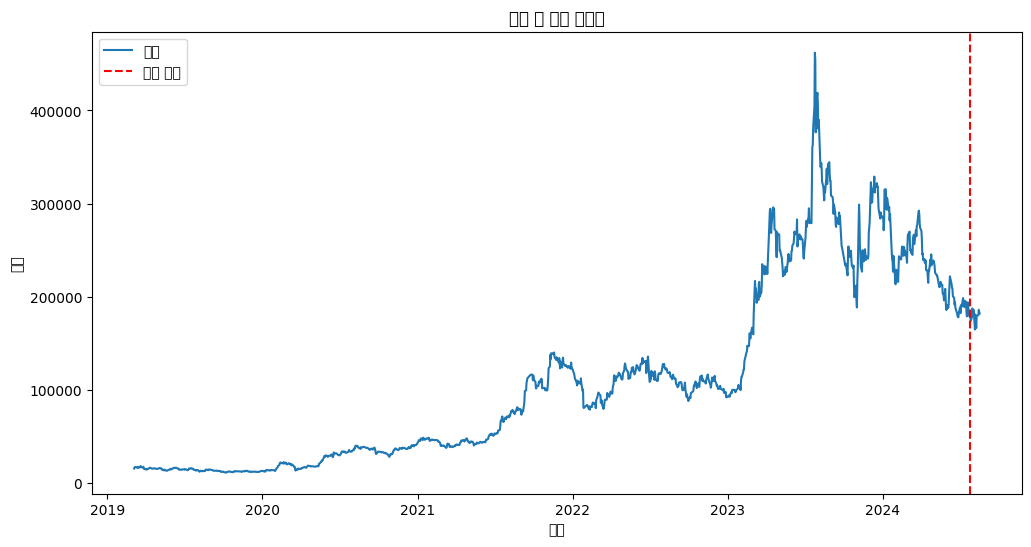

타겟 변수 클래스 분포:
Bear_Market
0    697
1    651
Name: count, dtype: int64
교차 검증 평균 점수: 0.4794


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib


# 데이터 로드 및 전처리
file_path = '/content/에코프로비엠.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
# 기존 특성 생성 (5일 간격 특성 포함)
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['Volatility_5'] = data['Close'].rolling(window=5).std()
data['EMA_5'] = data['Close'].ewm(span=5, adjust=False).mean()
data['Return_5'] = data['Close'].pct_change(periods=5)
data['Momentum_5'] = data['Close'] - data['Close'].shift(5)
data['Log_Volume'] = np.log(data['Volume'].replace(0, np.nan))  # 0을 NaN으로 대체
# 거래량 파생 특성 생성
data['SMA_Volume_5'] = data['Volume'].rolling(window=5).mean()
data['Volatility_Volume_5'] = data['Volume'].rolling(window=5).std()
data.fillna(method='bfill', inplace=True)
# 무한값 및 결측치 처리
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
# 목표 변수 정의 (하락장 여부)
def define_bear_market(data, window=5, drop_threshold=-0.03):
    data['Bear_Market'] = 0
    for i in range(len(data) - window):
        if (data['Close'].iloc[i:i + window].pct_change().min() <= drop_threshold):
            data['Bear_Market'].iloc[i + window - 1] = 1
    return data
data = define_bear_market(data, window=5, drop_threshold=-0.03)
data.dropna(inplace=True)
# 특성과 목표 변수 설정
features = data[['Close', 'SMA_5', 'Volatility_5', 'EMA_5', 'Return_5', 'Momentum_5', 'Log_Volume', 'SMA_Volume_5', 'Volatility_Volume_5']]
target = data['Bear_Market']
# 데이터 스케일링 (StandardScaler 사용)
scaler_X = StandardScaler()
features_scaled = scaler_X.fit_transform(features)
# 최근 30일 평일 데이터로 예측 수행
recent_dates = pd.bdate_range(start='2024-07-15', end='2024-08-14', freq='B')
recent_data = data[data['Date'].isin(recent_dates)]
recent_data = recent_data.sort_values('Date')
# 데이터 길이 조정
seq_length = min(len(recent_data) - 1, 30) if len(recent_data) >= 30 else 1
# 시퀀스 데이터 생성
def create_sequences(X, y, seq_length):
    sequences = []
    labels = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i + seq_length])
        labels.append(y[i + seq_length])
    return np.array(sequences), np.array(labels)
X_seq, y_seq = create_sequences(features_scaled, target, seq_length)
# 데이터 분리 (SMOTE 제거, stratify 추가)
if len(X_seq) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X_seq.reshape((X_seq.shape[0], -1)), y_seq, test_size=0.3, random_state=42, stratify=y_seq)
    # XGBoost 모델 정의 (분류)
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)
    # 예측
    y_pred = model.predict(X_test)
    # 성능 평가
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['하락장 없음', '하락장']))
    # 날짜별 예측 수행
    predictions = []
    if len(recent_data) >= seq_length:
        for i in range(len(recent_data) - seq_length):
            recent_features = recent_data.iloc[i:i + seq_length][['Close', 'SMA_5', 'Volatility_5', 'EMA_5', 'Return_5', 'Momentum_5', 'Log_Volume', 'SMA_Volume_5', 'Volatility_Volume_5']].values
            recent_features_scaled = scaler_X.transform(recent_features)
            recent_features_seq = recent_features_scaled.flatten().reshape(1, -1)
            # 다음 날 하락장 여부 예측
            prediction = model.predict(recent_features_seq)[0]
            prediction_label = '하락장' if prediction == 1 else '하락장 없음'
            prediction_date = recent_data.iloc[i + seq_length]['Date']
            predictions.append({
                'Date': prediction_date,
                'Prediction': prediction_label
            })
        # 예측 결과를 데이터프레임으로 변환
        predictions_df = pd.DataFrame(predictions)
        # 예측 결과 출력
        if not predictions_df.empty:
            print("예측 결과:")
            for _, row in predictions_df.iterrows():
                print(f"{row['Date'].strftime('%Y-%m-%d')}의 예측: {row['Prediction']}")
        else:
            print("예측할 수 있는 데이터가 없습니다.")
    else:
        print("최근 데이터가 시퀀스를 생성할 만큼 충분하지 않습니다.")
else:
    print("데이터가 부족하여 훈련할 수 없습니다.")
# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='종가')
plt.axvline(x=pd.to_datetime('2024-07-25'), color='r', linestyle='--', label='예측 시작')
plt.title('종가 및 예측 포인트')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.legend()
plt.show()
# 타겟 변수의 클래스 분포 확인
target_counts = target.value_counts()
print("타겟 변수 클래스 분포:")
print(target_counts)
from sklearn.model_selection import cross_val_score
# XGBoost 모델 정의 (교차 검증)
model = xgb.XGBClassifier(eval_metric='mlogloss')
# 교차 검증 수행
cv_scores = cross_val_score(model, X_seq.reshape((X_seq.shape[0], -1)), y_seq, cv=5)
print(f"교차 검증 평균 점수: {cv_scores.mean():.4f}")
# 모델 훈련 및 평가
model.fit(X_train, y_train)